<a href="https://colab.research.google.com/github/alvaroguarda/cats-dogs/blob/main/Transfer_learning_casts_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning para reconhecimento de Gatos e Cachorros




In [1]:
# Libraries
%matplotlib inline

import os
import numpy as np
import keras

import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense
from keras.models import Model

import shutil

In [2]:
# Baixando o dataset cats_vs_dogs a ser utilizado no Transfer Learning
!wget https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip \
  -O kagglecatsanddogs.zip

!unzip -q kagglecatsanddogs.zip
!rm kagglecatsanddogs.zip
!ls

--2025-08-13 21:56:48--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.193.24.207, 2600:1417:76:98b::317f, 2600:1417:76:993::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.193.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs.zip’

kagglecatsanddogs.z 100%[===================>] 786.67M  78.1MB/s    in 7.4s    

2025-08-13 21:56:56 (107 MB/s) - ‘kagglecatsanddogs.zip’ saved [824887076/824887076]

 CDLA-Permissive-2.0.pdf   PetImages  'readme[1].txt'   sample_data


In [3]:
root = 'PetImages'

categories = [x[0] for x in os.walk(root) if x[0]][1:]
#categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)


['PetImages/Cat', 'PetImages/Dog']


In [11]:
# set the number de images to be used each per category
num_images_per_category = 100

# helper function to load image and return it and input vector
def get_image(path):
    try:
        if os.path.getsize(path) > 0: # Check if file is not empty
          img = image.load_img(path, target_size=(224, 224))
          x = image.img_to_array(img)
          x = np.expand_dims(x, axis=0)
          x = preprocess_input(x)
          return img, x
    except Exception as e:
        print(f"Error loading image {path}: {e}")
    return None, None

# load all the images from root folder
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    i = 0
    for img_path in images:
        i += 1
        if i > num_images_per_category:
            break
        img, x = get_image(img_path)
        if img is not None: # Only append if the image was loaded successfully
            data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

In [12]:
# create training / validation / test split (70%, 15%, 15%)
np.random.shuffle(data)
train_split, val_split = 0.7, 0.15
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

# separate data for labels
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 200 images from 2 categories
train / validation / test split: 140, 30, 30
training data shape:  (140, 224, 224, 3)
training labels shape:  (140, 2)


In [6]:
# Baixando a RNA já treinada
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Adaptação da VGG

In [7]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [13]:
history = model_new.fit(x_train, y_train,
                        batch_size=128,
                        epochs=15,
                        validation_data=(x_val, y_val))

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 109s 28s/step - accuracy: 0.6837 - loss: 0.6115 - val_accuracy: 0.7000 - val_loss: 0.5731
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 138s 28s/step - accuracy: 0.5516 - loss: 0.6266 - val_accuracy: 0.7000 - val_loss: 0.5579
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 143s 25s/step - accuracy: 0.5949 - loss: 0.6169 - val_accuracy: 0.7000 - val_loss: 0.5358
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 108s 28s/step - accuracy: 0.8063 - loss: 0.5226 - val_accuracy: 0.6333 - val_loss: 0.6056
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 140s 27s/step - accuracy: 0.7305 - loss: 0.5348 - val_accuracy: 0.6333 - val_loss: 0.6101
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 142s 28s/step - accuracy: 0.7496 - loss: 0.5327 - val_accuracy: 0.7333 - val_loss: 0.5187
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 149s 36s/step - accuracy: 0.8211 - loss: 0.4703 - val_accuracy: 0.8333 - val_loss: 0.4708
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 137s 26s/step - accuracy: 0.8163 - loss: 0.4678 - val_accuracy: 0.8333 - val_loss:

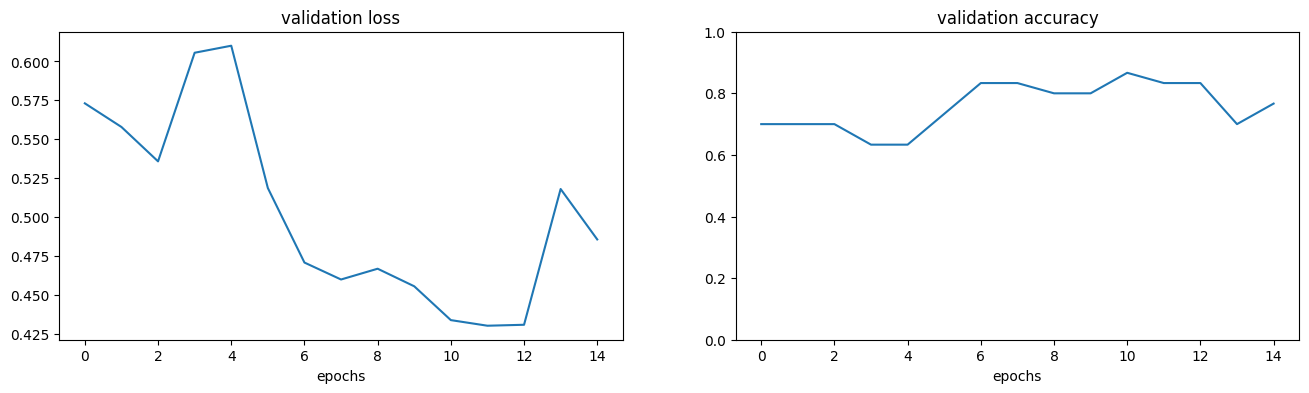

In [14]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [15]:
# a final validation on the test set
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.4576040804386139
Test accuracy: 0.7666666507720947


--------------------------------------------------


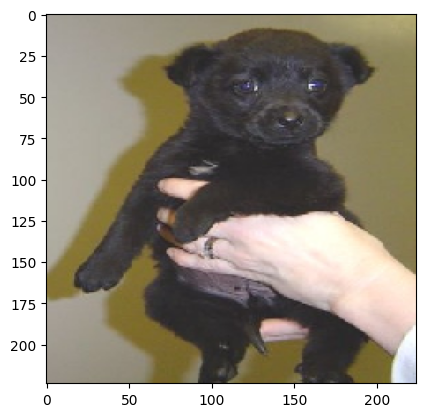

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The probability of being a cat is:  0.00021001058  %
The probability of being a dog is:  99.99979  %
--------------------------------------------------


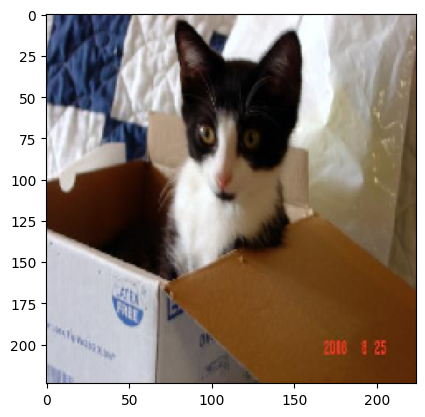

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
The probability of being a cat is:  99.91474  %
The probability of being a dog is:  0.08525699  %
--------------------------------------------------


In [17]:
# predict a new image
print("--------------------------------------------------")
dog = 'PetImages/Dog/200.jpg'
img_dog, x_dog = get_image(dog)
if img_dog is not None:
  plt.imshow(img_dog)
  plt.show()
  probabilities_dog = model_new.predict(x_dog)
  print("The probability of being a cat is: ", probabilities_dog[0][0]*100, " %")
  print("The probability of being a dog is: ", probabilities_dog[0][1]*100, " %")
else:
  print(f"Could not load image {dog}")

print("--------------------------------------------------")
cat = 'PetImages/Cat/200.jpg'
img_cat, x_cat = get_image(cat)
if img_cat is not None:
  plt.imshow(img_cat)
  plt.show()
  probabilities_cat = model_new.predict(x_cat)
  print("The probability of being a cat is: ", probabilities_cat[0][0]*100, " %")
  print("The probability of being a dog is: ", probabilities_cat[0][1]*100, " %")
else:
  print(f"Could not load image {cat}")
print("--------------------------------------------------")